In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, FormatStrFormatter, MultipleLocator, NullFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import os
from cmcrameri import cm
from scipy.interpolate import PchipInterpolator
from scipy.integrate import cumulative_trapezoid
import matplotlib.patheffects as pe
from copy import deepcopy

In [2]:
import utils.load_grid as lg
import feathers
from proteus.config import read_config
from proteus.utils.constants import M_earth, M_jupiter, R_earth, R_jupiter, secs_per_year

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'
# %matplotlib widget

In [4]:
fwl_dir = os.environ.get("FWL_DATA")

In [5]:
def gauss1d(v,param):
    if v > param["mu"]:
        sig2 = param["sigp"]**2
    else:
        sig2 = param["sigm"]**2
    return np.exp(-0.5 * (v-param["mu"])**2/sig2) #/ np.sqrt(2*np.pi*sig2)

def gauss2d(x,y, x_param, y_param):
    return gauss1d(x, x_param) * gauss1d(y, y_param)

In [41]:
def _get_exo_data():
    popfile = os.path.join(fwl_dir, "planet_reference", "Exoplanets", "DACE_PlanetS.csv")
    return pd.read_csv(popfile,comment="#")

def _get_mr_data():
    z19 = os.path.join(fwl_dir, "mass_radius", "Mass-radius", "Zeng2019")

    # Set paths
    curves = {
        # "Earth-like":           os.path.join(z19, "massradiusEarthlikeRocky.txt"),
        r"Rocky + 1% H$_2$, 500 K":     os.path.join(z19, "Earthlike1h500K1mbar.txt"),
        r"MgSiO$_3$":           os.path.join(z19, "massradiusmgsio3.txt"),
        r"Rocky + 0.3% H$_2$, 500 K":     os.path.join(z19, "Earthlike03h500K1mbar.txt"),
    }

    # Replace paths with the data
    for k in curves.keys():
        data = np.loadtxt(curves[k]).T
        mask = np.argsort(data[0])
        curves[k] = [data[0][mask],data[1][mask]]

    return curves

# Get exoplanet values from database
exo = _get_exo_data()
print(list(exo.keys()))

exo_mas_val = exo["Planet Mass [Mjup]"]             * M_jupiter / M_earth
exo_mas_upp = exo["Planet Mass - Upper Unc [Mjup]"] * M_jupiter / M_earth
exo_mas_low = exo["Planet Mass - Lower Unc [Mjup]"] * M_jupiter / M_earth

exo_rad_val = exo["Planet Radius [Rjup]"]             * R_jupiter / R_earth
exo_rad_upp = exo["Planet Radius - Upper Unc [Rjup]"] * R_jupiter / R_earth
exo_rad_low = exo["Planet Radius - Lower Unc [Rjup]"] * R_jupiter / R_earth

exo_age_val = np.array(exo["Stellar Age [Gyr]"]   )  * 1e9    # yr
exo_rho_val = np.array(exo["Planet Density [g/cm**3] - Computation"]) # g cm-3

# Get Mass-Radius curves from files
mrdata = _get_mr_data()

['Unnamed: 0', 'Planet Name', 'Planet Letter', 'Host Name', 'TIC ID', 'Gaia DR3 ID', 'Discovery Year', 'Discovery Method', 'Discovery Facility', 'Discovery Locale', 'Number of stars', 'Number of planets', 'Reference', 'ADS link', 'Last Updated', 'Planet Mass [Mjup]', 'Planet Mass - Upper Unc [Mjup]', 'Planet Mass - Lower Unc [Mjup]', 'Relative Mass Error', 'Planet Msin(i) [Mjup]', 'Planet Msin(i) - Upper Unc [Mjup]', 'Planet Msin(i) - Lower Unc [Mjup]', 'Planet Radius [Rjup]', 'Planet Radius - Upper Unc [Rjup]', 'Planet Radius - Lower Unc [Rjup]', 'Relative Radius Error', 'Orbital Period [days]', 'Orbital Period - Upper Unc [days]', 'Orbital Period - Lower Unc [days]', 'Orbit Semi-Major axis [au]', 'Orbit Semi-Major axis - Upper Unc [au]', 'Orbit Semi-Major axis - Lower Unc [au]', 'Source of the Orbit Semi-Major axis', 'Eccentricity', 'Eccentricity - Upper Unc', 'Eccentricity - Lower Unc', 'Eccentricity Upper Limit Flag', 'Insolation Flux [Earth Flux]', 'Insolation Flux - Upper Unc [Ea

In [7]:
t0 = 1e2
m_max = 5
m_min = 0.1

In [8]:
pgrid_dir = "data/shared/l98d_habrok3/"
cases = lg.get_cases(pgrid_dir, only_completed=False)
ncases = len(cases)

cnums = [int(s.split("_")[-1]) for s in cases]
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

confs = []
for f in cases:
    confs.append( read_config(f+"/init_coupler.toml") )

age_start = float(helps[0]["age_star"].iloc[0])

print("Done")

Helpfiles: 100%|██████████| 900/900 [01:04<00:00, 14.00it/s]


Done


In [19]:
age_obs = {"mu":4.94e9, "sigm":1.44e9, "sigp":1.44e9, "min":800e6}

cmap_obs = {
    "Rajpaul+24":  plt.get_cmap("Blues"),
    "Demangeon+21":plt.get_cmap("Greens"),
    "Luque+22":    plt.get_cmap("Greys"),
    "Cloutier+19": plt.get_cmap("Oranges"),
}

# densities
rho_obs =  {
    "Rajpaul+24"  :{"cmap":cmap_obs["Rajpaul+24"  ], "mu":3.45,  "sigm":1.0,   "sigp":0.59},
    "Demangeon+21":{"cmap":cmap_obs["Demangeon+21"], "mu":2.95,  "sigm":0.51,  "sigp":0.79},
    "Luque+22"    :{"cmap":cmap_obs["Luque+22"    ], "mu":3.17,  "sigm":0.73,  "sigp":0.85},
    "Cloutier+19" :{"cmap":cmap_obs["Cloutier+19" ], "mu":3.30,  "sigm":0.90,  "sigp":1.30},
}

# masses
mas_obs =  {
    "Rajpaul+24"  :{"cmap":cmap_obs["Rajpaul+24"  ], "mu":2.14,  "sigm":0.29,   "sigp":0.25},
    "Demangeon+21":{"cmap":cmap_obs["Demangeon+21"], "mu":1.94,  "sigm":0.28,  "sigp":0.28},
    "Luque+22"    :{"cmap":cmap_obs["Luque+22"    ], "mu":2.31,  "sigm":0.45,  "sigp":0.46},
    "Cloutier+19" :{"cmap":cmap_obs["Cloutier+19" ], "mu":2.31,  "sigm":0.45,  "sigp":0.46},
}

# radii
rad_obs =  {
    "Rajpaul+24"  :{"cmap":cmap_obs["Rajpaul+24"  ], "mu":1.521, "sigm":0.098, "sigp":0.119},
    "Demangeon+21":{"cmap":cmap_obs["Demangeon+21"], "mu":1.521, "sigm":0.098, "sigp":0.119},
    "Luque+22"    :{"cmap":cmap_obs["Luque+22"    ], "mu":1.58,  "sigm":0.08,  "sigp":0.08},
    "Cloutier+19" :{"cmap":cmap_obs["Cloutier+19" ], "mu":1.57,  "sigm":0.14,  "sigp":0.14},
}

## Density over time

In [20]:
plt.close("all")

In [83]:
def get_val(conf, help, key, idx=-1):

    # is in config
    if "." in key:
        return lg.descend_get(conf, key)

    # is in helpfile
    if key in help.keys():
        return float(help[key].iloc[idx])

    m_mant = float(help["M_mantle"].iloc[idx])
    m_planet = float(help["M_planet"].iloc[idx])

    # custom quantity
    if key == "H_wtpct":
        # H_kg = lg.descend_get(conf, "delivery.elements.H_ppmw") * 1e-6 * m_mant
        H_kg = help["H_kg_total"].iloc[idx]
        H_wt = H_kg / m_planet
        return H_wt * 100.0

    if key == "vols_wtpct":
        v_kg = 0.0
        for e in ("H","C","N","O","S"):
            v_kg = float(help[e+"_kg_total"].iloc[idx])
        v_kg = v_kg / m_planet
        return v_kg * 100.0

    # failure
    raise KeyError(f"Key {key} not supported")

3.50 < age Gyr < 6.38
Cases which match density/age observations:
[101, 190, 191, 279, 280, 281, 296, 369, 370, 371, 385, 386, 459, 460, 461, 475, 476, 549, 550, 551, 564, 565, 566, 639, 640, 641, 654, 655, 656, 729, 730, 731, 744, 745, 746, 819, 820, 821, 834, 835, 836]
3.2260113879157495
2.2804116224935127


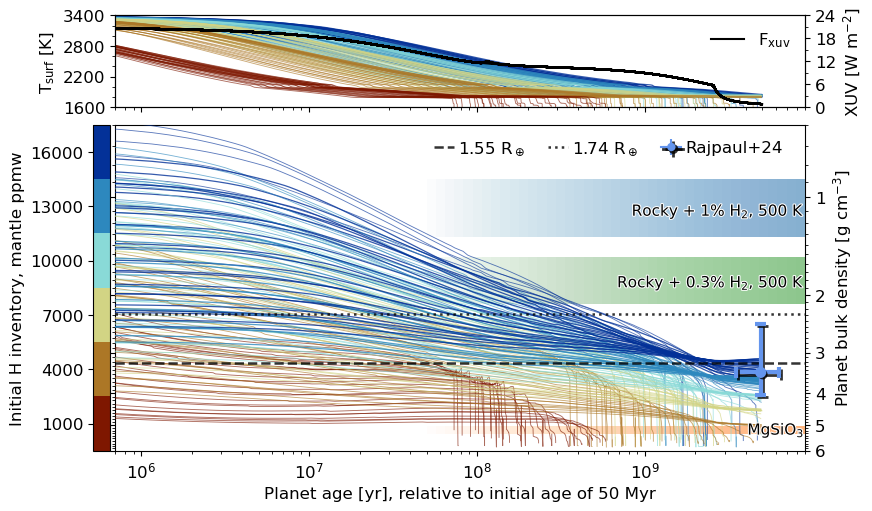

In [200]:
figscale=1.25
spr = 0.22
fig, axs = plt.subplots(2,1, figsize=(7*figscale,4*figscale),
                            sharex=True, height_ratios=(spr,1-spr) , layout='constrained')
axt = axs[0]
axr = axt.twinx()
ax  = axs[1]

tmin, tmax = 7e5, 9e9
xscale = "log"
yscale = "log"

plot_casenums = False
plot_running = False

# zkey = "outgas.fO2_shift_IW"
# zlbl = r"Mantle oxygen fugacity, $\Delta$IW"
# cmap = cm.batlow_r

zkey = "delivery.elements.H_ppmw"
zlbl = r"Initial H inventory, mantle ppmw"
cmap = cm.roma

# zkey = "H_wtpct"
# zlbl = r"Initial H inventory, wt% (total)"
# cmap = plt.get_cmap("eastern_rosella_r")

# zkey = "delivery.elements.SH_ratio"
# zlbl = r"Initial S inventory, S/H"
# cmap = cm.lipari

# zkey = "struct.mass_tot"
# zlbl = r"Planet mass [M$_\oplus$]"
# cmap = plt.get_cmap("princess_parrot")

# zkey = "cnums"
# zlbl = "Case number"
# cmap = plt.get_cmap("viridis")

controls = {}
# controls = {"outgas.fO2_shift_IW":-5}
# controls = {"struct.mass_tot":2.14}
# controls = {"delivery.elements.H_ppmw":8e3}
controls = {"delivery.elements.SH_ratio":8.0}

# Observations
def add_obs_contour(ax, x_obs, y_obs, x_samp, y_samp, label, colq=0.8):
    zo = 20
    clw = 3
    al = 0.7
    levels = 5

    z_arr = np.zeros((len(x_samp), len(y_samp)))
    for i,x in enumerate(x_samp):
        for j,y in enumerate(y_samp):
            z_arr[j,i] = gauss2d(x, y, x_obs, y_obs)
    z_max = np.amax(z_arr)
    z_arr /= z_max
    vmin = -0.2

    cmap = deepcopy(y_obs["cmap"])
    # ax.contour(x_samp,y_samp, z_arr, alpha=al, cmap='Greys_r', vmin=0, vmax=99999, zorder=zo-1, levels=levels, linewidths=clw+2)
    # ax.contour(x_samp,y_samp, z_arr, cmap='Greys', vmin=0, vmax=99999, zorder=zo-1, levels=levels, linewidths=clw)
    # ax.contour(x_samp,y_samp, z_arr, alpha=al, cmap=cmap, vmin=vmin, zorder=zo, levels=levels, linewidths=clw)

    c = 'cornflowerblue'
    effects = [ pe.SimpleLineShadow(alpha=0.8, linewidth=2, offset=(1.5, -1.5)),pe.Normal()]
    ax.errorbar([],[], xerr=1, yerr=1, label=label, color=c, marker='o', markersize=5, path_effects=effects)
    ax.errorbar(x_obs["mu"]-age_start,y_obs["mu"],
                    xerr=[[x_obs["sigm"]-age_start],[x_obs["sigp"]-age_start]],
                    yerr=[[y_obs["sigm"]],[y_obs["sigp"]]], capsize=4, mew=3,
                    zorder=zo+1, color=c, elinewidth=clw,
                    marker='o',  markersize=5,
                    path_effects=effects) # legend entry

x_inp = np.linspace(tmin, tmax, 200)
y_inp = np.linspace(0.1,  10,   200)
lit_ref = "Rajpaul+24"
for obs in (lit_ref,):
    add_obs_contour(ax, age_obs, rho_obs[obs], x_inp, y_inp, obs)


cmap = deepcopy(cmap)
zvals = []
for i in range(ncases):
    zvals.append(get_val(confs[i], helps[i], zkey))

zvals = np.unique(zvals)
norm = mpl.colors.Normalize(vmin=zvals[0], vmax=zvals[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ls = 'solid'
lw = 0.9
al = 0.8

age_min = age_obs["mu"]-age_obs["sigm"]
age_max = age_obs["mu"]+age_obs["sigp"]
print("%.2f < age Gyr < %.2f"%(age_min/1e9, age_max/1e9))

masses_all = []
radii_all   = []
matches_rho = []
for i in range(ncases):

    # get config
    skip = False
    for k in controls.keys():
        val = get_val(confs[i], helps[i], k)
        exp = controls[k]
        if not np.isclose(val, exp):
            skip = True
    if skip:
        continue
    if not plot_running and not (10 <= stts[cnums[i]] <= 19): # not completed
        continue

    # get data
    hf_crop = helps[i][3:]
    time = np.array(hf_crop["Time"])

    sim_rad = np.array(hf_crop["R_obs"])
    sim_mas = np.array(hf_crop["M_planet"])
    sim_rho = 3*sim_mas/(4*np.pi*sim_rad**3)  * 0.001
    sim_rad = deepcopy(sim_rad)/R_earth
    sim_mas = deepcopy(sim_mas)/M_earth

    sim_Fxuv = np.array(hf_crop["F_xuv"])  # W/m^2
    sim_Rxuv = np.array(hf_crop["R_xuv"])
    sim_Pxuv = sim_Rxuv**2 * np.pi * 4 * sim_Fxuv  # Watts
    sim_Exuv = cumulative_trapezoid(sim_Pxuv, time, initial=0) # J

    sim_mmw = np.array(hf_crop["atm_kg_per_mol"]) * 1e3 # g/mol

    sim_Tsurf = np.array(hf_crop["T_surf"])

    sim_esc_rate = np.array(hf_crop["esc_rate_total"]) # kg/s
    sim_esc_rate *= secs_per_year * 1e6 # kg/yr
    sim_esc_rate /= 1e20

    z = get_val(confs[i], helps[i], zkey)


    # store mass statistics
    masses_all.extend(sim_mas)
    radii_all.extend(sim_rad)

    # does this case pass through observed region?
    rho_param = rho_obs[lit_ref]
    rho_min = rho_param["mu"]-rho_param["sigm"]*0.5
    rho_max = rho_param["mu"]+rho_param["sigp"]*0.5
    mask = np.argwhere( (sim_rho >= rho_min) & ( sim_rho <= rho_max))
    ages = time[mask] + age_start
    if np.any( (ages >= age_min) & (ages <= age_max)):
        # roughly matches
        matches_rho.append(cnums[i])
        _lw = lw
        _al = al
    else:
        # does not match
        _lw = lw * 0.7
        _al = al * 0.8

    # plot density
    color = sm.to_rgba(z)
    ax.plot(time, sim_rho, color=color, lw=_lw, alpha=_al, zorder=7,  ls='solid')

    # plot surface temperature
    axt.plot(time, sim_Tsurf, color=color, lw=_lw, alpha=_al)

    # plot Fxuv
    axr.plot(time, sim_Fxuv, color='black', alpha=0.7)

    # annotate
    if plot_casenums:
        x = time[-1]
        y = sim_rho[np.argmin(np.abs(time - x))]
        if x > tmin:
            ax.text(x, y, str(cnums[i]), fontsize=8, zorder=9, color='crimson',
                    horizontalalignment='center', verticalalignment='center')

# legend entry
axr.plot([], [], c='black',  lw=1.5, zorder=0, label=r"F$_\text{xuv}$", ls='solid')
# ax.plot( [], [], c='purple', lw=lw,  alpha=al, zorder=0, label= "Simulations", ls='solid')

print("Cases which match density/age observations:")
print(matches_rho)

# M-R curves
mass_min = np.amin(masses_all)
mass_max = np.amax(masses_all)
al = 0.6
for k in mrdata.keys():
    m_curve = mrdata[k][0] * M_earth
    r_curve = mrdata[k][1] * R_earth
    rho_curve = 3*m_curve/(4*np.pi*r_curve**3)  * 0.001

    rho_interp = PchipInterpolator(m_curve, rho_curve)
    rho_min = rho_interp(mass_min * M_earth)
    rho_max = rho_interp(mass_max * M_earth)
    rho_med = 0.5 * (rho_min + rho_max)

    nsamp = 42
    mr_r = tmax
    mr_l = np.logspace(np.log10(5e7), np.log10(mr_r), nsamp)
    c = None
    for i in range(0,nsamp):
        if i == 0:
            c = ax.fill_between([1,2],1,2).get_fc() # generate colour
            ax.text(mr_r*0.99, rho_med, k,
                     horizontalalignment='right', verticalalignment='center', fontsize=11, zorder=20,
                     path_effects=[pe.Stroke(linewidth=1.5, foreground='w'), pe.Normal()])
        else:
            lbl = ""
        ax.fill_between([mr_l[i], mr_r], rho_min,  rho_max, color=c, zorder=4, alpha=0.7/nsamp, ec='none')

# Exoplanets
# ax.scatter(exo_age_val-age_start, exo_rho_val,
#             color='gold', label="Exoplanets", s=6, zorder=5, edgecolors='none')

# Radius valley
def _rho_from_rad(R_val):
    m_ref = np.median(masses_all) * M_earth
    rho_ref = 3 * m_ref / (4 * np.pi * (R_val*R_earth)**3) / 1e3 # g/cm^3
    print(rho_ref)
    return rho_ref


R_ref = [1.55, 1.74]
al = 0.8
col = 'k'
rho_ref = [_rho_from_rad(r) for r in R_ref]
ax.axhline(y=rho_ref[0], lw=lw*2, ls='dashed', zorder=12, alpha=al,
                    label=r"%.2f R$_\oplus$"%R_ref[0], color=col)

ax.axhline(y=rho_ref[1], lw=lw*2, ls='dotted', zorder=12, alpha=al,
                    label=r"%.2f R$_\oplus$"%R_ref[1], color=col)

ax.set_xlim(left=tmin, right=tmax)
ax.set_xlabel("Planet age [yr], relative to initial age of %g Myr"%(age_start/1e6))
ax.set_xscale(xscale)

ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_label_position("right")
ax.set_ylabel(r"Planet bulk density [g cm$^{-3}$]")
ax.set_yscale(yscale)
ax.set_ylim(bottom=6, top=0.6)
ax.yaxis.set_major_formatter(FormatStrFormatter("%g"))
ax.yaxis.set_major_locator(MultipleLocator(1.0))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# axt.set_ylabel("Escape rate\n" + r"[10$^{20}$ kg/yr]")
# axt.set_yticks([0, 1, 2, 3])
# axt.set_ylim(bottom=0)

axt.set_ylabel(r"T$_\text{surf}$ [K]")
axt.set_yticks([1600, 2200, 2800, 3400])
axt.set_ylim(1600, 3400)
axt.yaxis.set_minor_locator(MultipleLocator(200))

axr.set_ylabel(r"XUV [W m$^{-2}$]")
axr.set_yticks([0, 6, 12, 18, 24])
axr.set_ylim(bottom=0, top=24)
axr.yaxis.set_minor_locator(MultipleLocator(3))
axr.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), frameon=False)

cbpad = -0.09
if len(zvals) > 7:
    fig.colorbar(sm, ax=[ax], pad=cbpad, label=zlbl, location='left')
else:
    fig.colorbar(sm, ax=[ax], pad=cbpad, label=zlbl, values=zvals, ticks=zvals, location='left')

leg = ax.legend(loc='upper right', ncols=4, frameon=False, bbox_to_anchor=(0.98, 0.98),
                    handletextpad=0.25, columnspacing=1.4, borderpad=0, handlelength=1.2)
leg.set_zorder(99)
fig.savefig("output/fig_density.pdf",bbox_inches='tight')
plt.show()

Plot histogram of H_wtpct at idx=4


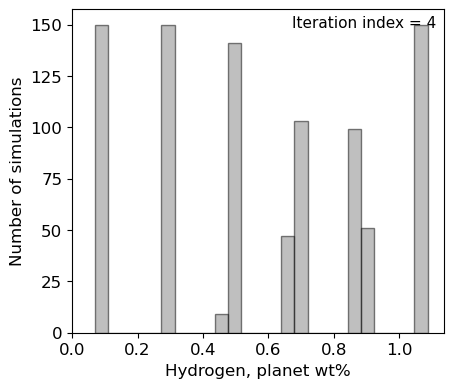

Values: min=0.0689804218569741   med=0.5758473705975103   max=1.0867393001584311
Plot histogram of vols_wtpct at idx=4


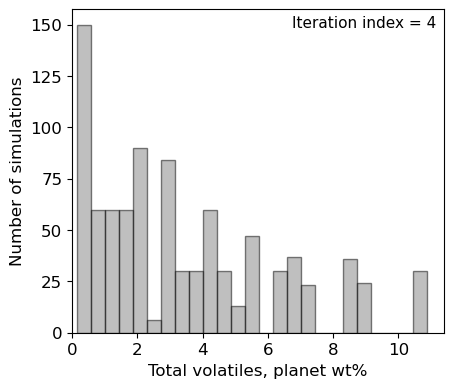

Values: min=0.1379624750369313   med=2.7386806239539965   max=10.863195456207203
Plot histogram of P_surf at idx=4


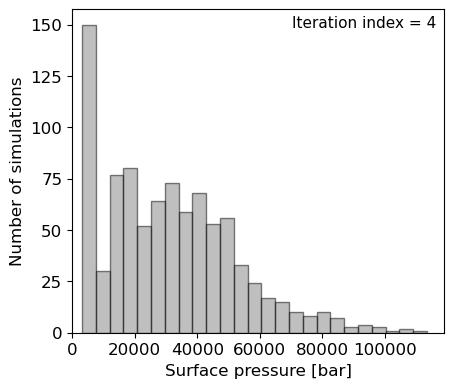

Values: min=3182.1447622   med=29429.7093995   max=113401.15734


In [127]:
def make_hist(mkey, nbins=50, idx=-1, xlbl=None):
    print(f"Plot histogram of {mkey} at idx={idx}")

    figscale = 1.2
    fig,ax = plt.subplots(1,1, figsize=(4*figscale, 3.5*figscale))

    mvals = []
    for i in range(ncases):
        mvals.append(get_val(confs[i], helps[i], mkey, idx=idx))
    mvals = np.array(mvals)
    if mkey == "R_obs":
        mvals /= R_earth

    counts, bins = np.histogram(mvals, bins=nbins)
    ax.hist(bins[:-1], bins, weights=counts, color='grey', edgecolor='black', alpha=0.5)

    if xlbl is not None:
        ax.set_xlabel(xlbl)
    else:
        ax.set_xlabel(mkey)
    ax.set_ylabel("Number of simulations")
    ax.set_xlim(left=0)
    ax.yaxis.set_major_locator(MultipleLocator(25))

    ax.text(0.98,0.98,f"Iteration index = {idx}", fontsize=11,
                transform=ax.transAxes, ha='right', va='top', zorder=99)

    fig.savefig("output/hist_%s.pdf"%mkey, bbox_inches='tight')
    plt.show()

    print(f"Values: min={np.amin(mvals)}   med={np.median(mvals)}   max={np.amax(mvals)}")


vars = [
    ("H_wtpct",     "Hydrogen, planet wt%"),
    ("vols_wtpct",  "Total volatiles, planet wt%"),
    ("P_surf",      "Surface pressure [bar]"),
]
for mkey,mlbl in vars:
    make_hist(mkey, nbins=25, idx=4, xlbl=mlbl)

## Parameter projection

In [24]:
alphabet = "abcdefghijklmnop"

In [25]:
%matplotlib inline

Plotting parameter projection over density, t=4940 Myr
Plotting delivery.elements.H_ppmw
Plotting outgas.fO2_shift_IW
Plotting delivery.elements.SH_ratio
Plotting struct.mass_tot
Plotting atm_kg_per_mol
Plotting Phi_global
Plotting H2S_vmr


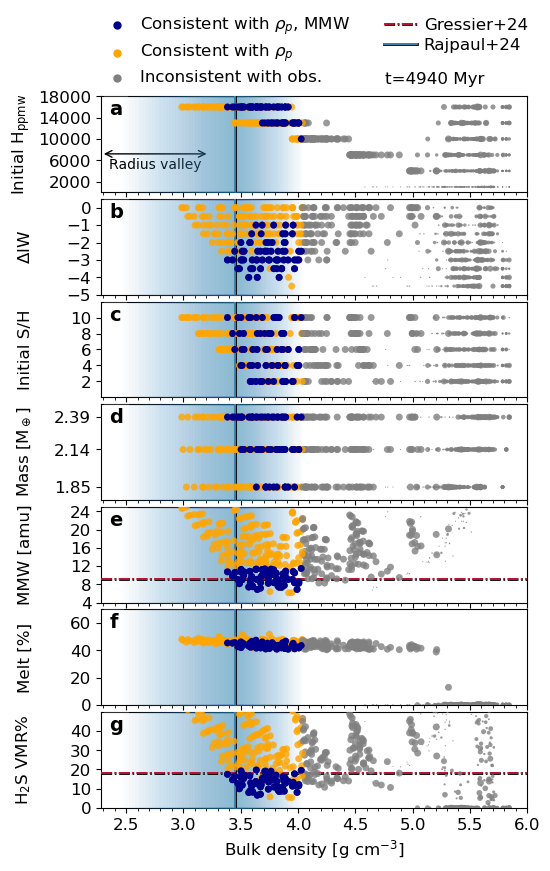

Case 838: rho = 3.45, mmw = 24.3, d = 0.0%
Case 368: rho = 3.45, mmw = 10.6, d = 0.1%
Case 839: rho = 3.45, mmw = 24.2, d = 0.1%
Case 370: rho = 3.46, mmw = 12.1, d = 0.2%
Case 636: rho = 3.44, mmw = 17.5, d = 0.2%
Case 837: rho = 3.47, mmw = 24.5, d = 0.4%
Case 281: rho = 3.43, mmw = 9.8, d = 0.6%
Case 547: rho = 3.43, mmw = 15.1, d = 0.6%
Case 194: rho = 3.48, mmw = 9.1, d = 0.7%
Case 459: rho = 3.48, mmw = 14.8, d = 0.8%
Case 457: rho = 3.48, mmw = 12.8, d = 0.8%
Case 458: rho = 3.42, mmw = 12.7, d = 0.9%
Case 749: rho = 3.49, mmw = 22.4, d = 1.1%
Case 725: rho = 3.49, mmw = 16.7, d = 1.1%
Case 191: rho = 3.49, mmw = 8.2, d = 1.1%
Case 635: rho = 3.49, mmw = 14.6, d = 1.2%
Case 545: rho = 3.50, mmw = 12.6, d = 1.3%
Case 372: rho = 3.50, mmw = 13.6, d = 1.4%
Case 748: rho = 3.50, mmw = 22.5, d = 1.4%
Case 455: rho = 3.50, mmw = 10.7, d = 1.5%
Case 283: rho = 3.50, mmw = 11.3, d = 1.5%
Case 546: rho = 3.51, mmw = 15.3, d = 1.6%
Case 726: rho = 3.39, mmw = 19.6, d = 1.7%
Case 278: rho 

In [ ]:
def project(target_time:float, fmt='pdf', show=True,
                print_ranked=False, print_cnums=False,
                mmw_param=None):

    tnow = age_obs["mu"]

    tstr = "%04.0f"%(target_time/1e6)
    print(f"Plotting parameter projection over density, t={tstr} Myr")

    keys = []
    lbls = []
    scls = []
    lims = []
    tcks = []
    yobs = []

    keys.append( "delivery.elements.H_ppmw" )
    lbls.append( r"Initial H$_\text{ppmw}$" )
    scls.append( 1.0 )
    lims.append( (0, 18e3) )
    tcks.append( [2e3, 6e3, 10e3, 14e3, 18e3] )
    yobs.append( None )

    keys.append( "outgas.fO2_shift_IW" )
    lbls.append( r"$\Delta$IW" )
    scls.append( 1.0 )
    lims.append( (-5, 0.5) )
    tcks.append( [-5, -4, -3, -2, -1, 0] )
    yobs.append( None )

    keys.append( "delivery.elements.SH_ratio" )
    lbls.append( "Initial S/H" )
    scls.append( 1.0 )
    lims.append( (0, 12) )
    tcks.append( [2, 4, 6, 8, 10] )
    yobs.append( None )

    keys.append( "struct.mass_tot" )
    lbls.append( r"Mass [M$_\oplus$]" )
    scls.append( 1.0 )
    lims.append( (1.75, 2.49) )
    tcks.append( [1.85, 2.14, 2.39] )
    yobs.append( None )

    keys.append( "atm_kg_per_mol" )
    lbls.append( r"MMW [amu]" )
    scls.append( 1000.0 )
    lims.append( (4, 25) )
    tcks.append( [4, 8, 12, 16, 20, 24 ] )
    yobs.append( 9.18 )

    keys.append( "Phi_global" )
    lbls.append( r"Melt [%]" )
    scls.append( 100.0 )
    lims.append( (0, 70) )
    tcks.append( [0, 20, 40, 60] )
    yobs.append( None )

    keys.append( "H2S_vmr" )
    lbls.append( r"H$_2$S VMR%" )
    scls.append( 100.0 )
    lims.append( (0, 50) )
    tcks.append( [0, 10, 20, 30, 40] )
    yobs.append( 10**-0.74*100 )

    # keys.append( "P_surf" )
    # lbls.append( r"P$_\text{surf}$" )
    # scls.append( 1.0 )
    # lims.append( (0, None) )
    # tcks.append( [] )

    controls = {}
    # controls = {"delivery.elements.H_ppmw":13e3, "delivery.elements.SH_ratio":10.0}
    # controls = {"struct.mass_tot": 2.39}

    incl_obs = [lit_ref] #, "Demangeon+21", "Luque+22"]
    marker = 'o'
    ms = 25
    lw = 1.2
    al = 0.8
    xmin, xmax = min(rho_ref), 6.0

    rho_param = rho_obs[lit_ref]
    rho_min = rho_param["mu"]-rho_param["sigm"]
    rho_max = rho_param["mu"]+rho_param["sigp"]

    mmw_min = mmw_param["mu"]-mmw_param["sigm"]
    mmw_max = mmw_param["mu"]+mmw_param["sigp"]

    c_rho_mmw = '#00008B'
    c_rho     = 'orange'
    c_other   = 'grey'
    c_incomp  = 'brown'

    # init plot
    figscale = 1.1
    nax = len(keys)
    fig,axs = plt.subplots(nax, 1, figsize=(5*figscale,1.2*figscale*nax))

    # legend entries for scatter points
    def map_size(t):
        mf = 1-(tnow-t)/tnow # marker size scale factor
        return max(mf*ms, 0.4)

    # axs[0].scatter([], [], s=map_size(target_time),
    #                     c='k', alpha=al, label=f"{tstr} Myr")
    # axs[0].scatter([], [], s=map_size(tnow),
    #                     c='k', alpha=al,  label="%.0f Myr"%(tnow/1e6))

    s = map_size(target_time)
    axs[0].scatter([], [], s=s, c=c_rho_mmw, label=r"Consistent with $\rho_p$, MMW")
    axs[0].scatter([], [], s=s, c=c_rho,     label=r"Consistent with $\rho_p$")
    axs[0].scatter([], [], s=s, c=c_other,  label="Inconsistent with obs.")

    # legend entry for free chemistry retrieval
    fc_col = 'crimson'
    fc_lw = lw
    fc_al = 1.0
    fc_ls = 'dashdot'
    axs[0].axhline(-1e4, color=fc_col, lw=fc_lw, ls=fc_ls,
                         alpha=fc_al, label="Gressier+24",
                         path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

    # plot results
    for j in range(nax):
        key = keys[j]
        scl = scls[j]
        axs[j].set_ylabel(lbls[j])
        xarr = []  # x vals
        yarr = []  # y vals
        sarr = []  # marker sizes
        darr = []  # deviation from obs.
        carr = []  # colors
        harr = []  # mask for highlighted points
        garr = []  # mask for completed points - neglecting running cases

        if show:
            print("Plotting "+key)

        # loop over all simulations
        for i in range(ncases):

            # included?
            skip = False
            if controls:
                for k in controls:
                    if not np.isclose(controls[k], lg.descend_get(confs[i],k)):
                        skip = True
            if skip:
                continue

            # find closest index in helpfile
            help = helps[i].iloc[3:]
            t_arr = np.array(help["Time"]) + age_start
            idx_close = np.argmin(np.abs(t_arr - target_time))
            t = t_arr[idx_close]

            # get mmw
            mmw = help["atm_kg_per_mol"].iloc[idx_close] * 1e3 # g/mol

            # get x value, density
            x = help["rho_obs"].iloc[idx_close] / 1e3

            # marker colour
            h = False
            g = True
            if not (10 <= stts[cnums[i]] <= 19): # not completed
                carr.append(c_incomp)
                g = False
                # continue

            elif rho_min <= x <= rho_max:

                # matches mmw?
                if mmw_min <= mmw <= mmw_max:
                    carr.append(c_rho_mmw)
                    h = True
                else:
                    carr.append(c_rho)

            else:
                carr.append(c_other) # completed, does not match obs

            # get y value, from key
            if "." in key:
                y = lg.descend_get(confs[i], key)
            else:
                y = help[key].iloc[idx_close]
            y *= scl

            # get distance from 'true' value
            if t > age_obs["mu"]-age_obs["sigm"]*2:
                d = abs(x - rho_obs[lit_ref]["mu"])/rho_obs[lit_ref]["mu"] * 100.0 # pct difference
            else:
                d = 1e99
            darr.append([cnums[i],x,mmw,d])

            # store values
            s = map_size(t)
            sarr.append(s)
            xarr.append(x)
            yarr.append(y)
            harr.append(h)
            garr.append(g)

            if print_cnums:
                if (lims[j][1] is None or y <= lims[j][1]) and (lims[j][0] is None or y >= lims[j][0]):
                    axs[j].text(x,y,str(cnums[i]), fontsize=7, color='magenta', zorder=40, horizontalalignment='center', verticalalignment='center')

        xarr = np.array(xarr)
        yarr = np.array(yarr)
        sarr = np.array(sarr)
        carr = np.array(carr)
        darr = np.array(darr)

        # plot all points
        axs[j].scatter(xarr[garr],yarr[garr], s=sarr[garr], color=carr[garr],
                            marker=marker, edgecolor='none', zorder=10, alpha=al)

        # plot those which match both density and mmw:
        axs[j].scatter(xarr[harr],yarr[harr], s=sarr[harr], color=carr[harr],
                            marker=marker, edgecolor='none', zorder=11)

        # get axis limits
        yl, yr = axs[j].get_ylim()
        if lims[j][0] is not None:
            yl = lims[j][0]
        if lims[j][1] is not None:
            yr = lims[j][1]

        # draw observations of density
        x_med = rho_param["mu"]
        c = rho_param["cmap"](0.6)

        axs[j].axvline(x=x_med, color=c, label=lit_ref, ls='solid', lw=lw,
                            zorder=6, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

        nsamp = 40
        for i in range(nsamp):
            x_min = x_med - rho_param["sigm"] * i/nsamp
            x_max = x_med + rho_param["sigp"] * i/nsamp

            # right side
            height = gauss1d(x_max, rho_param) / gauss1d(x_med,rho_param)
            axs[j].fill_betweenx([yl, yr], x_med, x_max, zorder=4, alpha=height/nsamp, color=c)

            # left side
            height = gauss1d(x_min, rho_param) / gauss1d(x_med, rho_param)
            axs[j].fill_betweenx([yl, yr], x_min, x_med, zorder=4, alpha=height/nsamp, color=c)

        # set limits
        axs[j].set_ylim(yl, yr)
        axs[j].set_xlim(min(rho_ref), xmax)
        if len(tcks[j]) > 0:
            axs[j].set_yticks(tcks[j])

        # add panel label in top left
        axs[j].text(0.02, 0.96, f'{alphabet[j]}', fontsize=14, zorder=99, fontweight='bold',
                        horizontalalignment='left', verticalalignment='top', transform=axs[j].transAxes,
                        bbox=dict(facecolor='w', alpha=0.2, ec='none'))

        # draw free-chemistry retrieval line
        if yobs[j] is not None:
            axs[j].axhline(yobs[j], color=fc_col, lw=fc_lw, ls=fc_ls, zorder=7,
                            alpha=fc_al, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

        # remove ticks
        if j != nax-1:
            axs[j].set_xticklabels([])

    # add time annotation
    axs[0].text(0.9,1.1,"t=%.0f Myr"%(target_time/1e6),
                    transform=axs[0].transAxes, ha='right', va='bottom')

    # add legend
    axs[0].legend(loc='lower center',bbox_to_anchor=(0.5,0.98),
                ncols=2, handletextpad=0.4, labelspacing=0.3, borderpad=0.3,
                frameon=False, )

    # radius valley annotation
    y = np.median(axs[0].get_ylim())*0.8
    axs[0].annotate("", xy=(rho_ref[0], y), xytext=(rho_ref[1], y), arrowprops=dict(arrowstyle="<->", lw=1, color='black'))
    axs[0].text(np.median(rho_ref), y*0.9, r"Radius valley", ha='center', va='top', fontsize=10, color='black')

    # add x-labels
    axs[-1].set_xlabel(r"Bulk density [g cm$^{-3}$]")
    for ax in axs:
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.xaxis.set_major_locator(MultipleLocator(0.5))

    # move things
    fig.align_ylabels(axs[:])
    fig.subplots_adjust(hspace=0.07)

    # plot and save
    if show:
        plt.show()
        fpath = f"output/fig_density_blame.{fmt}"
    else:
        plt.close("all")
        fpath = f"output/density_blame_{tstr}.{fmt}"


    fig.savefig(fpath, bbox_inches='tight')

    # print ranking
    if print_ranked:
        ind = np.argsort( darr[:,-1] )
        darr = darr[ind]
        for i in range(len(darr)):
            cn  = darr[i,0]
            rho = darr[i,1]
            mmw = darr[i,2]
            dst = darr[i,3]
            print("Case %3d: rho = %.2f, mmw = %.1f, d = %.1f%%"%(cn, rho, mmw, dst))

# nframes = 70
# for i,t in enumerate(np.linspace(50e6, 5e9, nframes)):
#     print("Frame %d/%d"%(i+1, nframes))
#     project(t, fmt='png', show=False)
#     print(" ")

mmw_ref = {
    "mu": 9.18,
    "sigm": 2.41,
    "sigp": 2.51
}

project(age_obs["mu"], fmt='pdf',
            print_ranked=True, print_cnums=False,
            mmw_param = mmw_ref)
print("Done")

In [27]:
cnums[515]
confs[515]["params"]["out"]

{'path': 'scratch/l98d_habrok3/case_00515/',
 'logging': 'INFO',
 'plot_fmt': 'png',
 'write_mod': 2,
 'plot_mod': 40,
 'archive_mod': 250,
 'remove_sf': True}

## Animation

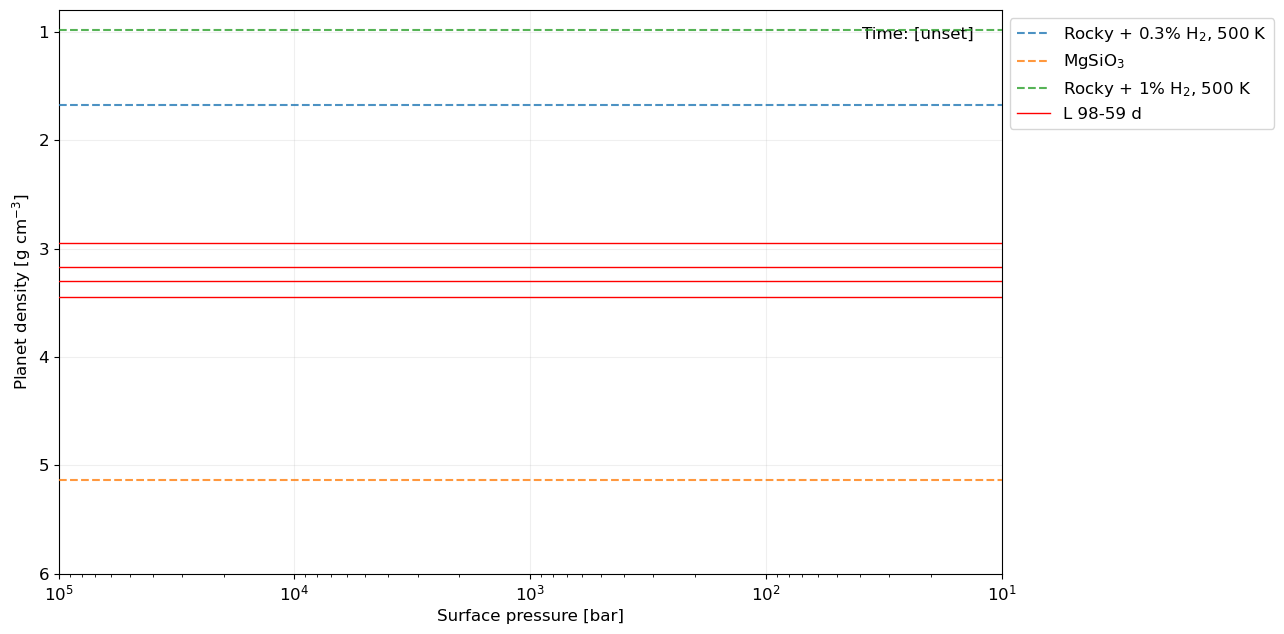

In [28]:
figscale=1.3
fig, ax = plt.subplots(1,1, figsize=(10*figscale,5*figscale))


ax.set_xlabel(r"Surface pressure [bar]")
ax.set_xlim(left=1e5, right=1e1)
ax.set_xscale("log")

ax.set_ylabel(r"Planet density [g cm$^{-3}$]")
ax.set_ylim(top=0.8, bottom=6)

zkey = "outgas.fO2_shift_IW"
norm = mpl.colors.Normalize(vmin=-4.5, vmax=-1)
sm = plt.cm.ScalarMappable(cmap=cm.batlow_r, norm=norm)
sm.set_array([])

controls = {}
controls = {"struct.mass_tot":2.14}


lines = []
iskip = []

# Create lines for simulations
for i in range(ncases):

    # included?
    skip = False
    if controls:
        for k in controls:
            if not np.isclose(controls[k], lg.descend_get(confs[i],k)):
                skip = True
    if skip:
        iskip.append(i)
        continue

    x,y = [], []
    if i == 0:
        lbl = "Simulations"
    else:
        lbl = ""
    c = sm.to_rgba(lg.descend_get(confs[i], zkey))
    l = ax.plot(x, y, color=c, lw=0.5, zorder=13, label=lbl, alpha=0.7)[0]
    lines.append(l)

# Create endpoints
tmax = 1e5
for i in range(ncases):
    if i in iskip:
        continue
    tmax = max(tmax, np.amax(helps[i]["Time"]))

# M-R curves
for k in mrdata.keys():
    m_arr = mrdata[k][0] * M_earth
    r_arr = mrdata[k][1] * R_earth
    rho_arr = 3*m_arr/(4*np.pi*r_arr**3)  * 0.001

    # dummy colour
    color = ax.plot([1e9,1e10],[1e9,1e10])[0].get_color()

    # get this mass
    i  = np.argmin(np.abs(np.median(masses_all) * M_earth - m_arr))
    rho = rho_arr[i]
    l = ax.axhline(y=rho, label=k, linestyle='dashed', alpha=0.8, zorder=10, color=color)

    lines.append(l)

# Observations
lines.append(ax.axhline(y=2.95, lw=1.0, zorder=12, color='red', label="L 98-59 d"))
lines.append(ax.axhline(y=3.45, lw=1.0, zorder=12, color='red'))
lines.append(ax.axhline(y=3.17, lw=1.0, zorder=12, color='red'))
lines.append(ax.axhline(y=3.30, lw=1.0, zorder=12, color='red'))

# Time
l = ax.text(0.97, 0.97, "Time: [unset]", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
lines.append(l)

# Decorate
ax.grid(alpha=0.2, zorder=-2)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
fig.tight_layout()

def update(t):

    j = -1

    # for each case
    for i in range(ncases):

        if i in iskip:
            continue
        j += 1

        hf_all = helps[i]

        # get index of closest time
        idx_close = np.argmin(np.abs(t - hf_all["Time"]))
        hf_crop = hf_all.iloc[range(idx_close)]
        if len(hf_crop["Time"]) < 3:
            continue

        # get data
        time = np.array(hf_crop["Time"])
        sim_tmp = np.array(hf_crop["T_surf"])
        sim_psf = np.array(hf_crop["P_surf"])
        sim_rad = np.array(hf_crop["R_obs"])
        sim_mas = np.array(hf_crop["M_planet"])
        sim_rho = 3*sim_mas/(4*np.pi*sim_rad**3)  * 0.001

        sim_rad /= R_earth
        sim_mas /= M_earth

        y = sim_rho
        # x = sim_rad
        x = sim_psf

        iline = j
        # iscat = j + len(iskip)

        lines[iline].set_data(x, y)

        # is this the last sample?
        if idx_close >= len(hf_all)-1:
            ax.scatter(x[-1], y[-1], color='k', s=5, zorder=13, edgecolors='none')

    lines[-1].set_text("Time: %.1e yr"%t)

    return lines

duration = 9.0
nframes  = 2

# make animation
tmin = 2e6
time_arr = np.logspace(np.log10(tmin), np.log10(tmax), nframes)
# time_arr = np.linspace(tmin, tmax, nframes)
# ani = FuncAnimation(fig, update, frames=time_arr, blit=True, interval=duration/len(time_arr)*1e3)

# save and show
# ani.save(filename="output/animate.gif", writer="ffmpeg")
# HTML(ani.to_jshtml())